In [9]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

C:\Users\karathul\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\karathul\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [78]:
goog = pd.read_csv("C:\\Users\\karathul\\Downloads\\goog.csv")
goog.head()
# goog = goog.value

,Unnamed: 0,time,value,Date
0,1,1,392.830017,25-02-13
1,2,2,392.512085,26-02-13
2,3,3,397.305908,27-02-13
3,4,4,398.011322,28-02-13
4,5,5,400.490204,03-03-13


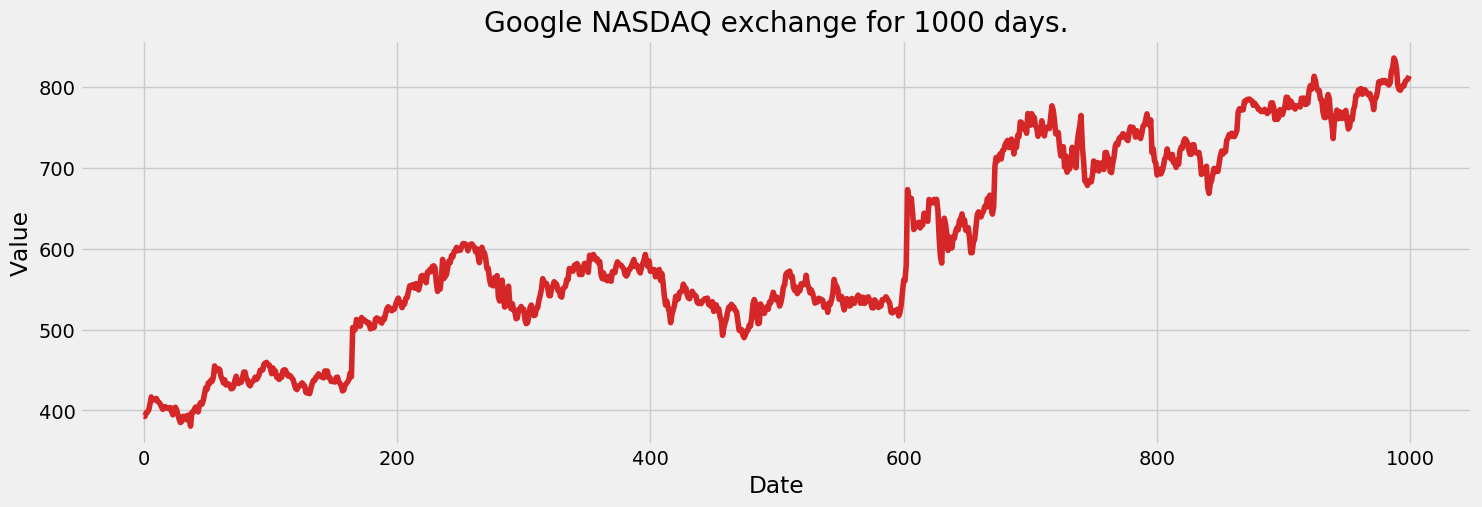

In [80]:
def plot_df(goog, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(goog, x=goog.index, y=goog.value, title='Google NASDAQ exchange for 1000 days.')

In [81]:
goog = goog.value
goog.head()

0    392.830017
1    392.512085
2    397.305908
3    398.011322
4    400.490204
Name: value, dtype: float64

<Figure size 1200x720 with 0 Axes>

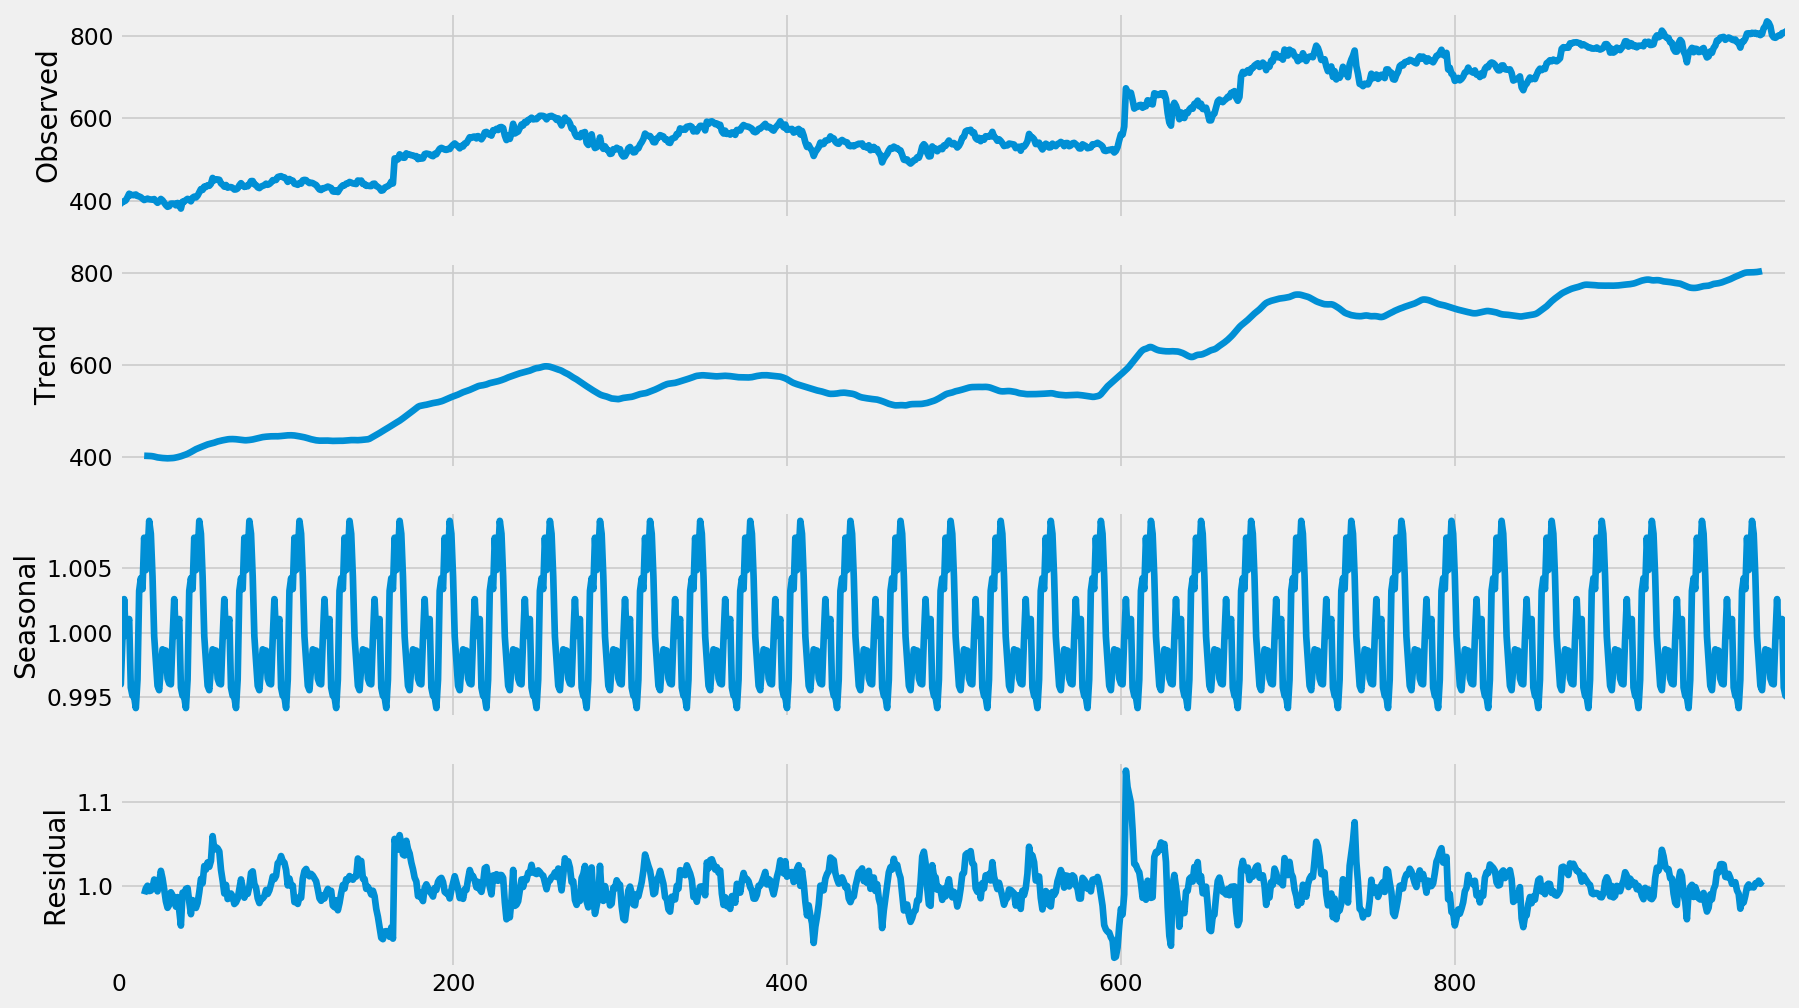

In [82]:
result = seasonal_decompose(goog, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

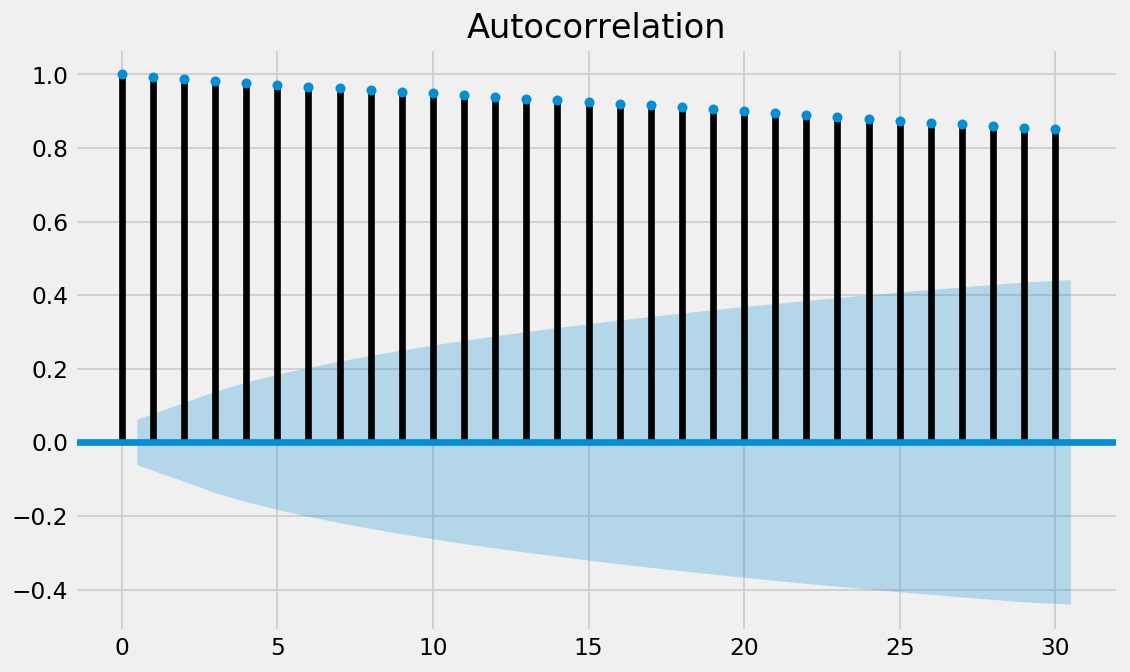

In [83]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(goog)
plt.show()

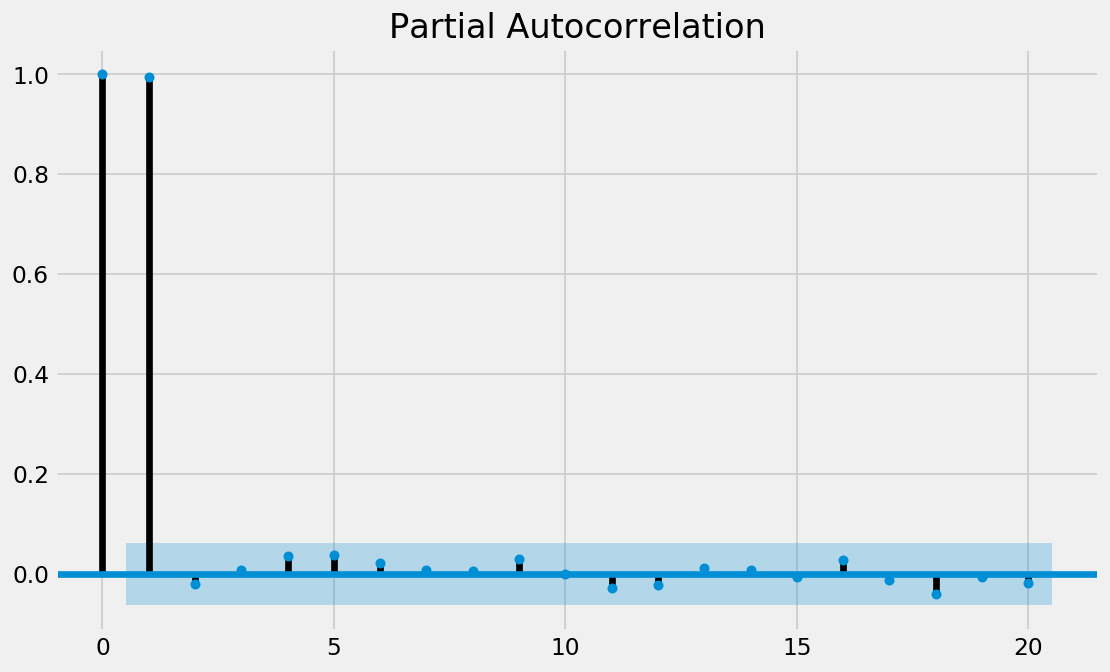

In [87]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(goog, lags=20)
plt.show()

No handles with labels found to put in legend.


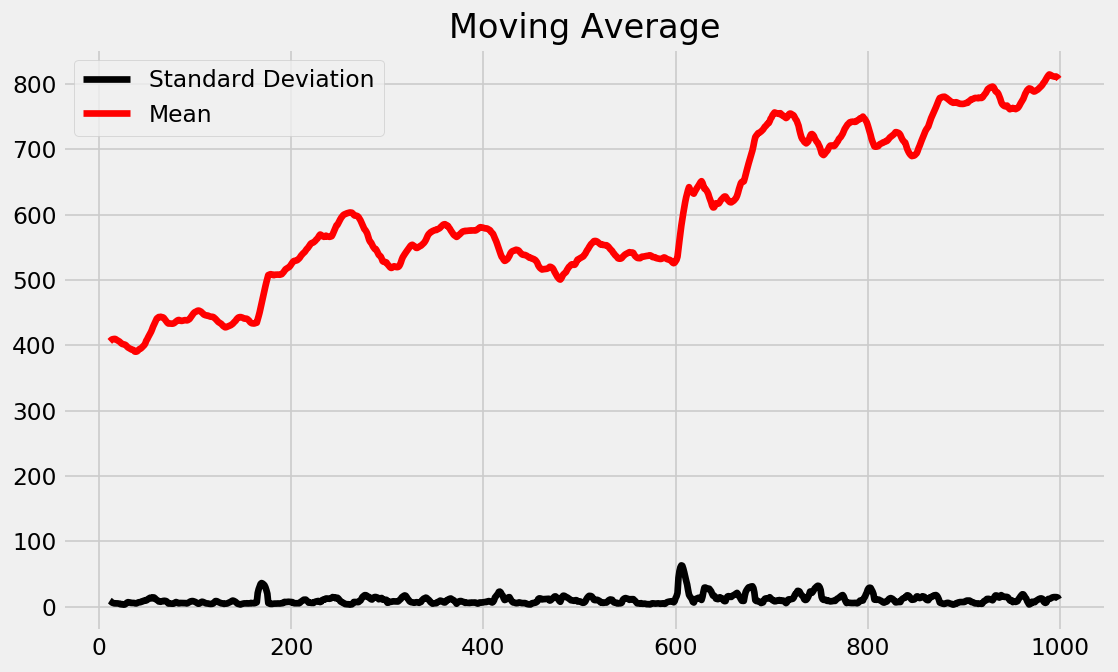

In [61]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
# df_log = np.log(goog)
moving_avg = goog.rolling(12).mean()
std_dev = goog.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

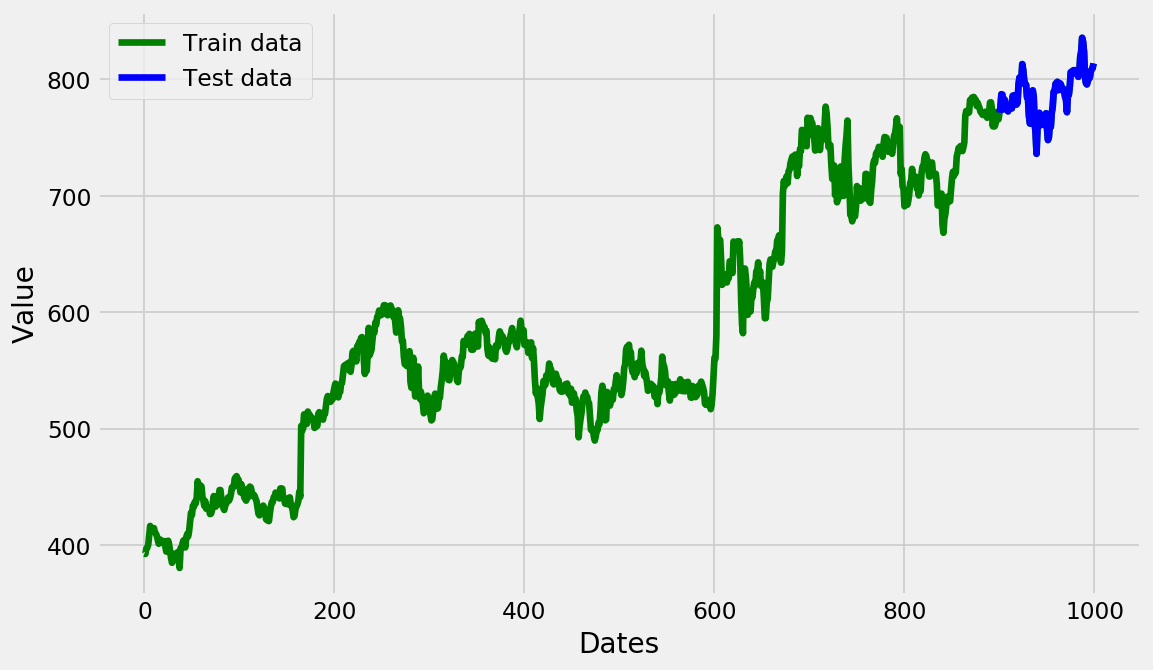

In [62]:
train_data, test_data = goog[3:int(len(goog)*0.9)], goog[int(len(goog)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Value')
plt.plot(goog, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [63]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Fit ARIMA: order=(0, 1, 0); AIC=6445.591, BIC=6455.187, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0); AIC=6446.737, BIC=6461.131, Fit time=0.042 seconds
Fit ARIMA: order=(0, 1, 1); AIC=6446.729, BIC=6461.123, Fit time=0.031 seconds
Fit ARIMA: order=(1, 1, 1); AIC=6448.727, BIC=6467.919, Fit time=0.451 seconds
Total fit time: 0.599 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  896
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3220.796
Method:                           css   S.D. of innovations              8.808
Date:                Fri, 27 Mar 2020   AIC                           6445.591
Time:                        02:19:17   BIC                           6455.187
Sample:                             1   HQIC                          6449.258
                                                                              
                 coef 

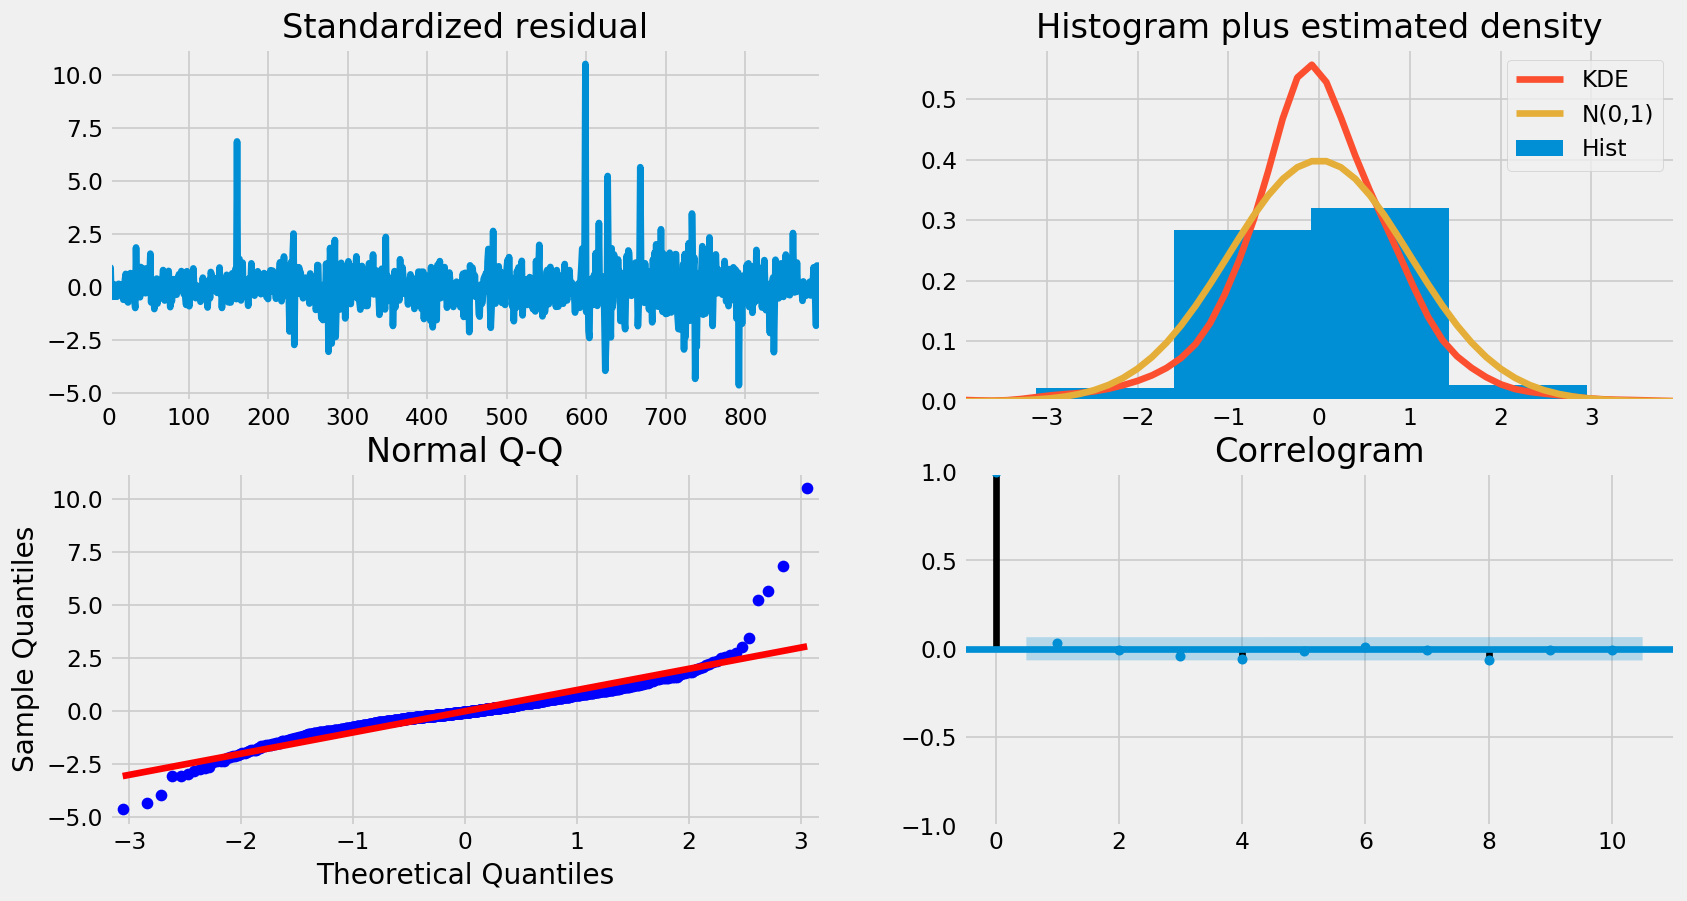

In [64]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.
Top Right: The density plot suggest normal distribution with mean zero.
Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.
Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.
Overall, it seems to be a good fit. Let’s start forecasting the stock prices.
Next, create an ARIMA model with provided optimal parameters p, d and q.

In [65]:
model = ARIMA(train_data, order=(0, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  896
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -3220.360
Method:                       css-mle   S.D. of innovations              8.804
Date:                Fri, 27 Mar 2020   AIC                           6448.721
Time:                        02:20:38   BIC                           6467.912
Sample:                             1   HQIC                          6456.054
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4103      0.302      1.358      0.175      -0.182       1.003
ma.L1.D.value     0.0307      0.034      0.916      0.360      -0.035       0.097
ma.L2.D.value    -0.0033      0.036     

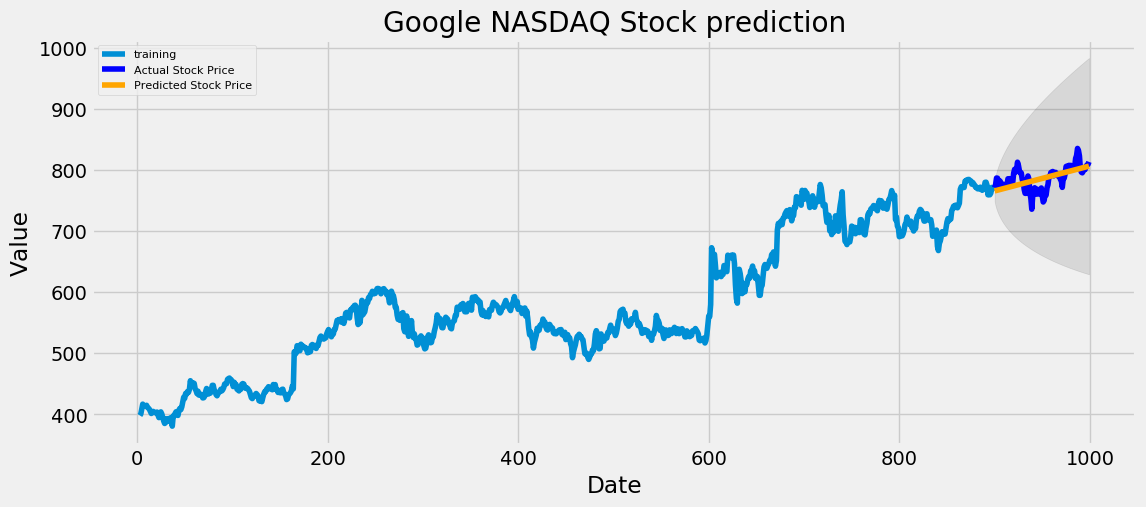

In [72]:
# Forecast
fc, se, conf = fitted.forecast(100, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Google NASDAQ Stock prediction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [74]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 266.8264800721048
MAE: 12.88906861990451
RMSE: 16.33482415185743
MAPE: 0.016478399436156182


Around 1.7% MAPE(Mean Absolute Percentage Error) implies the model is about 98.3% accurate in predicting the test set observations.